# NAS Net 5 Class

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import multi_gpu_model
from sklearn.utils import compute_class_weight

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/test'

epochs = 50
batch_size = 4

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [7]:
from keras.applications.nasnet import NASNetMobile

import numpy as np
base_model = NASNetMobile(weights='imagenet', input_shape=(img_width, img_height, 3), pooling = 'avg', include_top = False)

#adam = keras.optimizers.Adam(lr=1e-4)
#model.compile(loss='binary_crossentropy',
#              optimizer=adam,
#              metrics=['accuracy'])

x = base_model.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


adam = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [8]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

nb_train_samples = train_generator.n
nb_validation_samples = validation_generator.n

class_weights = compute_class_weight("balanced", np.unique(train_generator.classes), train_generator.classes)
class_weights

Found 435 images belonging to 5 classes.
Found 109 images belonging to 5 classes.


array([1.58181818, 0.44845361, 5.8       , 6.21428571, 0.55414013])

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

cb_list = [early_stop, reduce_lr]

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight = class_weights,
    callbacks = cb_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
108/108 [==============================] - 108s 1s/step - loss: 1.8750 - acc: 0.3850 - val_loss: 1.6142 - val_acc: 0.4537
Epoch 2/50
108/108 [==============================] - 44s 410ms/step - loss: 1.2115 - acc: 0.4853 - val_loss: 1.6726 - val_acc: 0.3905
Epoch 3/50
108/108 [==============================] - 44s 408ms/step - loss: 1.1604 - acc: 0.5054 - val_loss: 2.7933 - val_acc: 0.3524

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
108/108 [==============================] - 44s 406ms/step - loss: 1.0214 - acc: 0.5586 - val_loss: 1.4534 - val_acc: 0.4571
Epoch 5/50
108/108 [==============================] - 44s 405ms/step - loss: 1.0350 - acc: 0.5455 - val_loss: 1.4584 - val_acc: 0.3714
Epoch 6/50
108/108 [==============================] - 44s 405ms/step - loss: 0.9175 - acc: 0.6011 - val_loss: 1.2203 - val_acc: 0.5143
Epoch 7/50
108/1

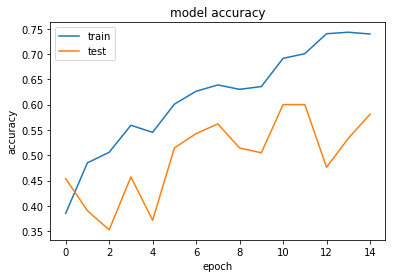

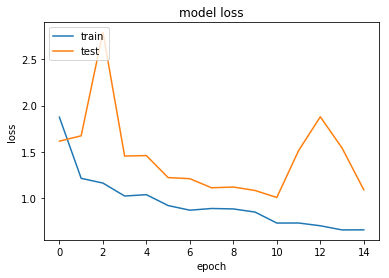

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
y_pred = []
y_true = []
for i in range(nb_validation_samples // batch_size):
    x, y = next(validation_generator)
    y_true.extend(np.argmax(y, axis = 1))
    y_pred.extend(np.argmax(model.predict(x), axis = 1))

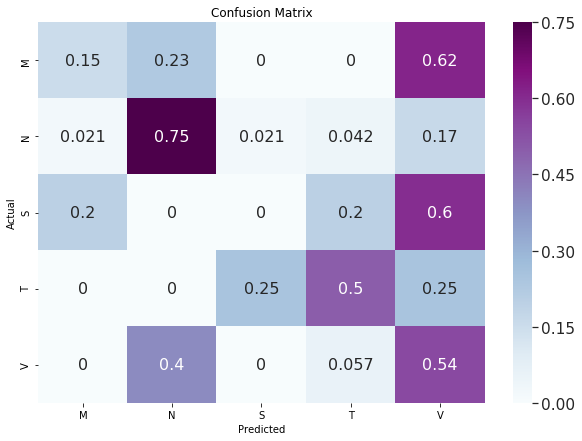

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

data = confusion_matrix(y_true, y_pred)
data = data / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
labels = ["M", "N", "S", "T", "V"]
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="BuPu", annot=True,xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})# font size

In [ ]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 10, replace=True)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:2])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:2])